<a href="https://colab.research.google.com/github/yoomhub/LSTM_Applications/blob/master/20190922_Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting Using Recurrent Neural Networks

This notebook is based on [TensorFlow Tutorial](https://www.tensorflow.org/beta/tutorials/text/time_series).

---

### Seongyoon Kim

Department of Computational Science and Engineering

20190922

---


## 1. Import Libraries



In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

TensorFlow 2.x selected.


## 2. Read Data

This [dataset](https://www.bgc-jena.mpg.de/wetter/) is recorded by the [Max-Planck-Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/index.php/Main/HomePage).

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016.

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

df = pd.read_csv(csv_path)

df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


The original dataset contains fourteen features. For simplicity, this section considers only three of the original fourteen. The features used are air temperature, atmospheric pressure, and air density.

In [3]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa75e759d68>,
      dtype=object)

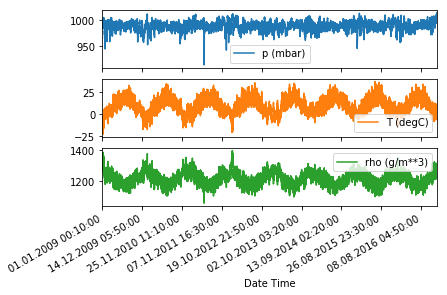

In [4]:
features.plot(subplots=True)

## 3. Data Preprocessing

It is important to normalize features before training a neural network. A common way to do so is by subtracting the mean and dividing by the standard deviation of each feature.

In [0]:
dataset = features.values
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)

dataset = (dataset-data_mean)/data_std

The below function `multivariate_data()` returns windows of time for the model to train on. It samples the past observation based on the step size given. The parameter `history_size` is the size of the past window of information. The `target_size` is how far in the future does the model need to learn to predict. The `target_size` is the label that needs to be predicted.

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      #labels.append(target[i:i+target_size])
      indices = range(i, i+target_size, step)
      labels.append(target[indices])

  return np.array(data), np.array(labels)

The first 300,000 rows of the data will be the training dataset, and there remaining will be the validation dataset. This amounts to ~2100 days worth of training data.

In this tutorial, the network is shown data from the last five (5) days, i.e. 720 observations that are sampled every hour. The sampling is done every one hour since a drastic change is not expected within 60 minutes. Thus, 120 observation represent history of the last five days. For the single step prediction model, the label for a datapoint is the temperature for 12 hours of observation.

In [0]:
TRAIN_SPLIT = 300000
past_history = 720
future_target = 72
STEP = 6

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [8]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (12,)


In [0]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [0]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out), np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out), np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

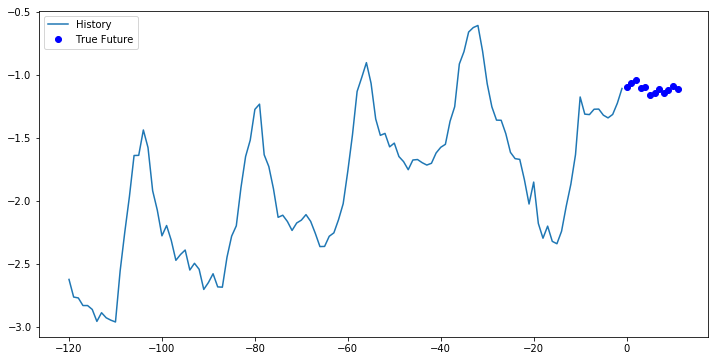

In [11]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

## 4. Construct and Train Networks

Since the task is a bit complicated, the model consists of two LSTM layers. Finally, since 12 predictions are made, the dense layer outputs 12 predictions.

In [12]:
Input = tf.keras.layers.Input(shape=x_train_multi.shape[-2:])

lstm1 = tf.keras.layers.LSTM(32, return_sequences=True)(Input)
lstm2 = tf.keras.layers.LSTM(16, activation='relu')(lstm1)

Pred = tf.keras.layers.Dense(12)(lstm2)

multi_step_model = tf.keras.Model(Input, Pred)

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipnorm=1.0), loss='mae')

multi_step_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 3)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 120, 32)           4608      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 12)                204       
Total params: 7,948
Trainable params: 7,948
Non-trainable params: 0
_________________________________________________________________


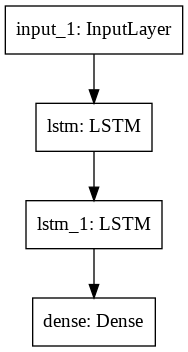

In [13]:
tf.keras.utils.plot_model(multi_step_model)

Let's train the model now. Due to the large size of the dataset, in the interest of saving time, each epoch will only run for 200 steps, instead of the complete training data as normally done.

In [14]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 49s 243ms/step - loss: 0.4764 - val_loss: 0.2884
Epoch 2/10
200/200 [==============================] - 43s 217ms/step - loss: 0.3062 - val_loss: 0.2508
Epoch 3/10
200/200 [==============================] - 43s 214ms/step - loss: 0.2542 - val_loss: 0.2122
Epoch 4/10
200/200 [==============================] - 43s 216ms/step - loss: 0.2260 - val_loss: 0.1971
Epoch 5/10
200/200 [==============================] - 43s 215ms/step - loss: 0.1946 - val_loss: 0.1907
Epoch 6/10
200/200 [==============================] - 43s 216ms/step - loss: 0.2054 - val_loss: 0.2176
Epoch 7/10
200/200 [==============================] - 44s 219ms/step - loss: 0.1994 - val_loss: 0.1938
Epoch 8/10
200/200 [==============================] - 44s 218ms/step - loss: 0.1941 - val_loss: 0.2010
Epoch 9/10
200/200 [==============================] - 43s 217ms/step - loss: 0.2000 - val_loss: 0.1839
Epoch 10/10
200/200 [=========

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

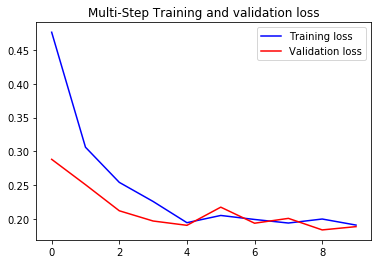

In [16]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

## 5. Predict a Multi-Step Future

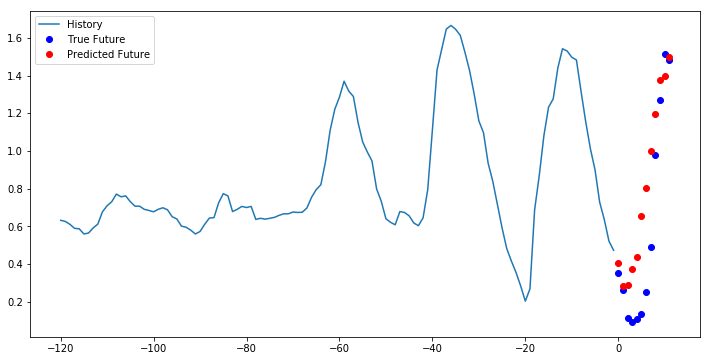

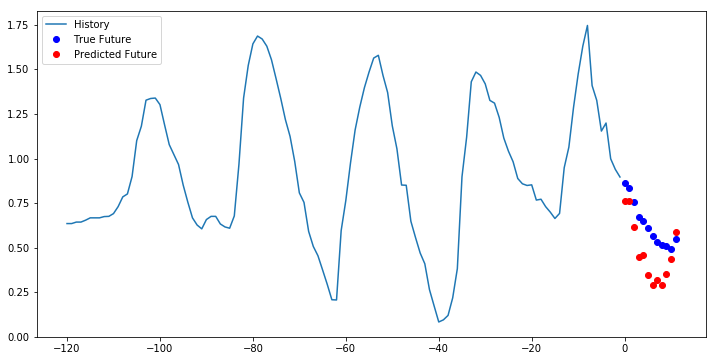

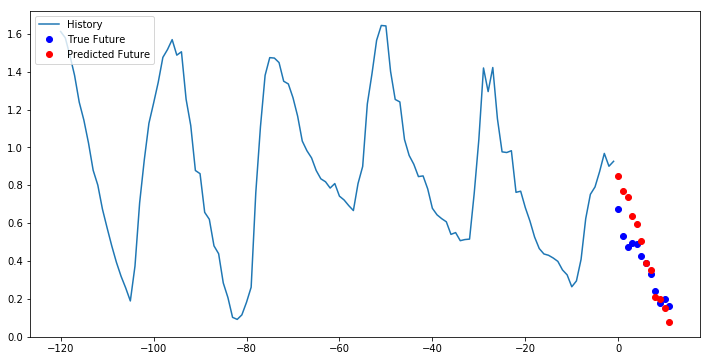

In [17]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])